In [1]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"

import torch
from matplotlib import pyplot as plt
from gsplat.rasterize import rasterize_gaussians
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# load model and dataset
model, renderer = GaussianModelLoader.search_and_load(
    "../outputs/garden/down_sample_4/",
    sh_degree=3,
    device="cuda",
)
print("Gaussian count: {}".format(model.get_xyz.shape[0]))
# dataset
dataparser_outputs = ColmapDataParser(
    os.path.expanduser("~/data/Mip-NeRF360/garden"),
    os.path.abspath(""),
    global_rank=0,
    params=ColmapParams(
        split_mode="experiment",
        reorient=True,
        down_sample_factor=4,
    ),
).get_outputs()
print("Test camera count: {}".format(len(dataparser_outputs.test_set.cameras)))

Gaussian count: 6023959
appearance group by camera id
loading colmap 3D points
down sample enabled
reorient scene
up vector = [-0.00169421 -0.8823425  -0.4706047 ]
reorienting cameras...
reorienting points...
[colmap dataparser] train set images: 161, val set images: 24, loaded mask: 0
Test camera count: 24


In [3]:
# pick a camera
camera = dataparser_outputs.test_set.cameras[0].to_device("cuda")
camera

Camera(R=tensor([[ 9.9992e-01, -5.9221e-04, -1.2980e-02],
        [-1.2848e-02, -1.9392e-01, -9.8093e-01],
        [-1.9361e-03,  9.8102e-01, -1.9391e-01]], device='cuda:0'), T=tensor([-0.3283, -1.9260,  3.9581], device='cuda:0'), fx=tensor(961.4100, device='cuda:0'), fy=tensor(962.8025, device='cuda:0'), fov_x=tensor(1.1869, device='cuda:0'), fov_y=tensor(0.8227, device='cuda:0'), cx=tensor(648.5000, device='cuda:0'), cy=tensor(420., device='cuda:0'), width=tensor(1297, device='cuda:0', dtype=torch.int16), height=tensor(840, device='cuda:0', dtype=torch.int16), appearance_id=tensor(0, device='cuda:0', dtype=torch.int32), normalized_appearance_id=tensor(0., device='cuda:0'), time=tensor(0., device='cuda:0'), distortion_params=tensor([0., 0., 0., 0.], device='cuda:0'), camera_type=tensor(0, device='cuda:0', dtype=torch.int8), world_to_camera=tensor([[ 9.9992e-01, -1.2848e-02, -1.9361e-03,  0.0000e+00],
        [-5.9221e-04, -1.9392e-01,  9.8102e-01,  0.0000e+00],
        [-1.2980e-02, -

torch.Size([3, 840, 1297])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


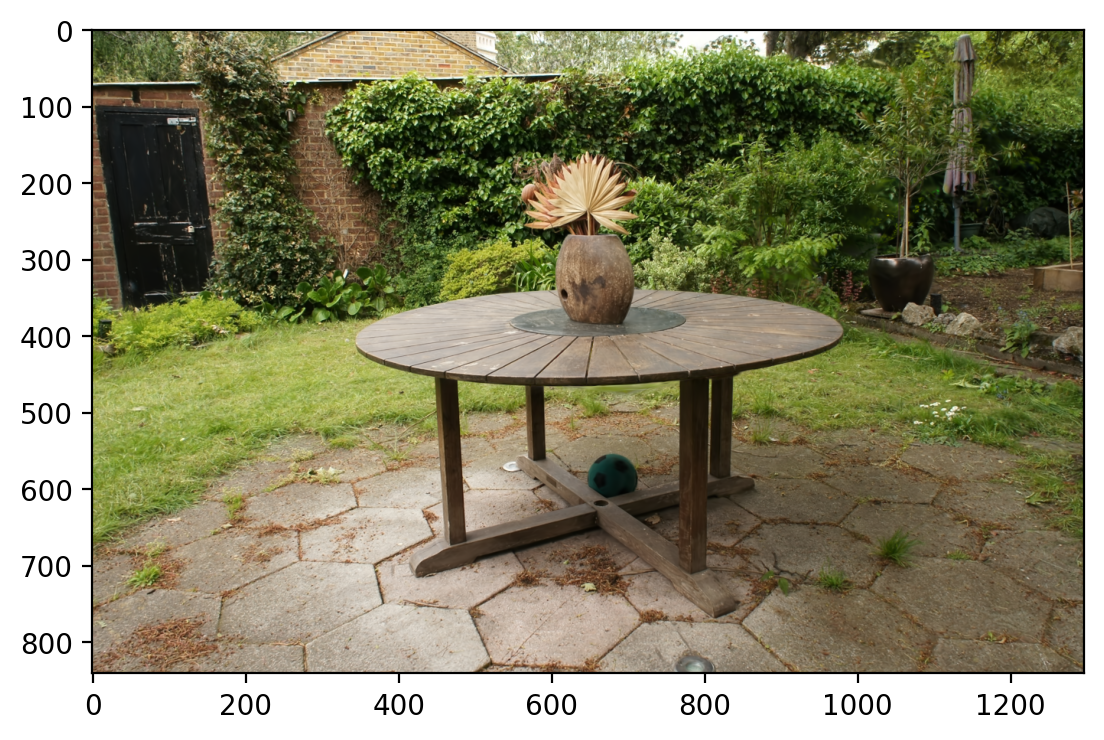

In [4]:
# Test image render
with torch.no_grad():
    results = renderer.render(
        model.get_xyz,
        opacity=model.get_opacity,
        scales=model.get_scaling,
        rotations=model.get_rotation,
        features=model.get_features,
        active_sh_degree=model.active_sh_degree,
        viewpoint_camera=camera,
        bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"),
    )
    print(results["render"].shape)

plt.imshow(results["render"].permute(1, 2, 0).cpu().numpy())
plt.show()

In [5]:
# transform the coordination of gaussians from world space to camera space
means_in_camera_space = torch.matmul(model.get_xyz, camera.world_to_camera[:3, :3]) + camera.world_to_camera[3, :3]
means_in_camera_space

tensor([[  4.6599,  -0.6643,   2.4909],
        [ -0.1210,  -0.3162,   4.4979],
        [  0.3989,   0.5733,   7.4471],
        ...,
        [-25.1966, -14.7891,  33.9328],
        [ 44.8824,  -8.9591,  23.6730],
        [ 45.8500,  -9.6184,  22.9410]], device='cuda:0')

In [6]:
# filter out invisible gaussians
min_depth = 0.2
is_in_the_front = means_in_camera_space[:, 2] > min_depth
valid_means_in_camera_space = means_in_camera_space[is_in_the_front]
is_in_the_front.shape, means_in_camera_space.shape[0], valid_means_in_camera_space.shape[0]

(torch.Size([6023959]), 6023959, 4703870)

In [7]:
# compute covariance 3D
def build_rotation_matrix(quaternion):
    # normalize quaternion
    quaternion_norm = torch.norm(quaternion, dim=-1)
    normalized_quaternion = quaternion / quaternion_norm[:, None]
    # build rotation matrix
    r = normalized_quaternion[:, 0]
    x = normalized_quaternion[:, 1]
    y = normalized_quaternion[:, 2]
    z = normalized_quaternion[:, 3]
    rotation_matrix = torch.zeros((quaternion.shape[0], 3, 3), dtype=quaternion.dtype, device=quaternion.device)
    rotation_matrix[:, 0, 0] = 1 - 2 * (y * y + z * z)
    rotation_matrix[:, 0, 1] = 2 * (x * y - r * z)
    rotation_matrix[:, 0, 2] = 2 * (x * z + r * y)
    rotation_matrix[:, 1, 0] = 2 * (x * y + r * z)
    rotation_matrix[:, 1, 1] = 1 - 2 * (x * x + z * z)
    rotation_matrix[:, 1, 2] = 2 * (y * z - r * x)
    rotation_matrix[:, 2, 0] = 2 * (x * z - r * y)
    rotation_matrix[:, 2, 1] = 2 * (y * z + r * x)
    rotation_matrix[:, 2, 2] = 1 - 2 * (x * x + y * y)

    return rotation_matrix


def compute_cov_3d(scales, scale_modifier, quaternion):
    """
    :param scales: 
    :param scale_modifier: 
    :param quaternion: in wxyz
    :return: 
    """
    n_gaussians, n_scales = scales.shape
    # build scaling matrix
    scaling_matrix = torch.zeros((n_gaussians, n_scales, n_scales), dtype=scales.dtype, device=scales.device)
    for i in range(n_scales):
        scaling_matrix[:, i, i] = scales[:, i] * scale_modifier

    # build rotation matrix
    rotation_matrix = build_rotation_matrix(quaternion)

    m = torch.bmm(rotation_matrix, scaling_matrix)
    sigma = torch.matmul(m, m.transpose(1, 2))

    return sigma


cov_3d = compute_cov_3d(model.get_scaling[is_in_the_front], 1.0, quaternion=model.get_rotation[is_in_the_front])
cov_3d, cov_3d.shape

(tensor([[[ 1.0128e-02, -3.6875e-03, -3.6780e-03],
          [-3.6875e-03,  1.6429e-03,  1.8879e-03],
          [-3.6780e-03,  1.8879e-03,  3.8256e-03]],
 
         [[ 1.3772e-05, -1.3363e-05,  3.2049e-06],
          [-1.3363e-05,  2.3899e-04, -2.2862e-05],
          [ 3.2049e-06, -2.2862e-05,  9.4482e-06]],
 
         [[ 4.6977e-04, -6.1177e-04,  1.0076e-04],
          [-6.1177e-04,  1.4510e-03, -3.1163e-04],
          [ 1.0076e-04, -3.1163e-04,  1.3740e-04]],
 
         ...,
 
         [[ 1.1669e-03,  3.3715e-04,  7.4886e-04],
          [ 3.3715e-04,  1.0906e-04,  2.4682e-04],
          [ 7.4886e-04,  2.4682e-04,  1.0924e-03]],
 
         [[ 3.4617e-03, -6.6471e-03, -1.8132e-03],
          [-6.6471e-03,  1.2764e-02,  3.4817e-03],
          [-1.8132e-03,  3.4817e-03,  9.4974e-04]],
 
         [[ 7.5796e-04, -1.0385e-03,  1.4977e-03],
          [-1.0385e-03,  2.8909e-03, -1.8127e-03],
          [ 1.4977e-03, -1.8127e-03,  5.5775e-03]]], device='cuda:0'),
 torch.Size([4703870, 3, 3]))

In [8]:
# compute covariance 2D
def compute_cov_2d(means_in_camera_space, tan_fovx, tan_fovy, focal_x, focal_y, cov_3d, world_to_camera):
    t = torch.clone(means_in_camera_space)
    limx = 1.3 * tan_fovx
    limy = 1.3 * tan_fovy
    txtz = t[:, 0] / t[:, 2]
    tytz = t[:, 1] / t[:, 2]
    
    t[:, 0] = torch.minimum(limx, torch.maximum(-limx, txtz)) * t[:, 2]
    t[:, 1] = torch.minimum(limy, torch.maximum(-limy, tytz)) * t[:, 2]
    
    means_in_camera_space = t

    

    # build Jacobian matrix J
    J = torch.zeros(
        (means_in_camera_space.shape[0], 3, 3),
        dtype=means_in_camera_space.dtype,
        device=means_in_camera_space.device
    )
    J[:, 0, 0] = focal_x / means_in_camera_space[:, 2]
    J[:, 0, 2] = -(focal_x * means_in_camera_space[:, 0]) / (means_in_camera_space[:, 2] * means_in_camera_space[:, 2])
    J[:, 1, 1] = focal_y / means_in_camera_space[:, 2]
    J[:, 1, 2] = -(focal_y * means_in_camera_space[:, 1]) / (means_in_camera_space[:, 2] * means_in_camera_space[:, 2])
    print("J={}".format(J))
    # the third row of J is ignored

    # build transform matrix W
    W = world_to_camera[:3, :3].T

    T = torch.matmul(J, W[None, :])

    cov_2d = T @ cov_3d @ T.transpose(1, 2)

    # Apply low-pass filter: every Gaussian should be at least
    # one pixel wide/high. Discard 3rd row and column.
    cov_2d[:, 0, 0] = cov_2d[:, 0, 0] + 0.3
    cov_2d[:, 1, 1] = cov_2d[:, 1, 1] + 0.3
    # TODO: compute the normalization factor

    return cov_2d[:, :2, :2]


cov_2d = compute_cov_2d(
    valid_means_in_camera_space, 
    tan_fovx=torch.tan(camera.fov_x / 2.),
    tan_fovy=torch.tan(camera.fov_y / 2.),
    focal_x=camera.fx, 
    focal_y=camera.fy, 
    cov_3d=cov_3d, 
    world_to_camera=camera.world_to_camera,
)
cov_2d

J=tensor([[[ 385.9692,    0.0000, -338.4522],
         [   0.0000,  386.5283,  103.0772],
         [   0.0000,    0.0000,    0.0000]],

        [[ 213.7453,    0.0000,    5.7506],
         [   0.0000,  214.0548,   15.0490],
         [   0.0000,    0.0000,    0.0000]],

        [[ 129.0993,    0.0000,   -6.9159],
         [   0.0000,  129.2863,   -9.9529],
         [   0.0000,    0.0000,    0.0000]],

        ...,

        [[  28.3327,    0.0000,   21.0383],
         [   0.0000,   28.3738,   12.3663],
         [   0.0000,    0.0000,    0.0000]],

        [[  40.6120,    0.0000,  -35.6122],
         [   0.0000,   40.6708,   15.3920],
         [   0.0000,    0.0000,    0.0000]],

        [[  41.9079,    0.0000,  -36.7486],
         [   0.0000,   41.9686,   17.5960],
         [   0.0000,    0.0000,    0.0000]]], device='cuda:0')


tensor([[[ 2.4082e+03,  6.5137e+02],
         [ 6.5137e+02,  5.5757e+02]],

        [[ 9.0060e-01, -8.0337e-02],
         [-8.0337e-02,  6.4074e-01]],

        [[ 9.2717e+00,  1.1022e+00],
         [ 1.1022e+00,  1.4649e+00]],

        ...,

        [[ 1.4615e+00, -5.9081e-01],
         [-5.9081e-01,  1.2203e+00]],

        [[ 3.8079e+01,  2.9139e+00],
         [ 2.9139e+00,  5.2475e-01]],

        [[ 1.0473e+01, -8.8579e+00],
         [-8.8579e+00,  1.3188e+01]]], device='cuda:0')

In [9]:
# invert covariance 2d
conic = torch.linalg.inv(cov_2d)
conic

tensor([[[ 6.0707e-04, -7.0919e-04],
         [-7.0919e-04,  2.6220e-03]],

        [[ 1.1229e+00,  1.4079e-01],
         [ 1.4079e-01,  1.5783e+00]],

        [[ 1.1845e-01, -8.9126e-02],
         [-8.9126e-02,  7.4970e-01]],

        ...,

        [[ 8.5072e-01,  4.1189e-01],
         [ 4.1189e-01,  1.0189e+00]],

        [[ 4.5666e-02, -2.5358e-01],
         [-2.5358e-01,  3.3138e+00]],

        [[ 2.2107e-01,  1.4849e-01],
         [ 1.4849e-01,  1.7557e-01]]], device='cuda:0')

In [10]:
# project to normalized plane
normalized_plan_means = valid_means_in_camera_space / (valid_means_in_camera_space[:, 2:] + 0.0000001)
# build intrinsics matrix
intrinsics_matrix = torch.tensor([
    [camera.fx, 0, camera.cx],
    [0, camera.fy, camera.cy],
    [0, 0, 1],
], dtype=normalized_plan_means.dtype, device=normalized_plan_means.device)
image_plane_means = normalized_plan_means @ intrinsics_matrix.T
normalized_plan_means[0], image_plane_means[0]

(tensor([ 1.8708, -0.2667,  1.0000], device='cuda:0'),
 tensor([2.4471e+03, 1.6325e+02, 1.0000e+00], device='cuda:0'))

In [11]:
# compute gaussian extent in screen space
mid = 0.5 * (cov_2d[:, 0, 0] + cov_2d[:, 1, 1])
mid_squared = mid * mid
cov_2d_det = torch.linalg.det(cov_2d)

mid_squared_and_det_diff = mid_squared[:, None] - cov_2d_det[:, None]
clamped_mid_squared_and_det_diff = torch.clamp_min(mid_squared_and_det_diff, 0.1)
sqrt_diff = torch.sqrt(clamped_mid_squared_and_det_diff)

lambda1 = mid[:, None] + sqrt_diff
lambda2 = mid[:, None] - sqrt_diff
radius = torch.ceil(3. * torch.sqrt(torch.maximum(lambda1, lambda2))).int()
lambda1, lambda2, radius

(tensor([[2.6145e+03],
         [1.0869e+00],
         [9.4244e+00],
         ...,
         [1.9439e+00],
         [3.8303e+01],
         [2.0792e+01]], device='cuda:0'),
 tensor([[3.5130e+02],
         [4.5444e-01],
         [1.3123e+00],
         ...,
         [7.3789e-01],
         [3.0000e-01],
         [2.8691e+00]], device='cuda:0'),
 tensor([[154],
         [  4],
         [ 10],
         ...,
         [  5],
         [ 19],
         [ 14]], device='cuda:0', dtype=torch.int32))

In [12]:
# build grid
BLOCK_X = 16
BLOCK_Y = 16
tile_grid = torch.tensor([
    (camera.width + BLOCK_X - 1) / BLOCK_X,
    (camera.height + BLOCK_Y - 1) / BLOCK_Y,
    1,
], device=means_in_camera_space.device).long()
block = torch.tensor([BLOCK_X, BLOCK_Y, 1], dtype=torch.int, device=means_in_camera_space.device)
tile_grid, block

(tensor([82, 53,  1], device='cuda:0'),
 tensor([16, 16,  1], device='cuda:0', dtype=torch.int32))

In [13]:
block_xy = block[0:2].unsqueeze(0)  # [1, 2[xy]]
rect_min = ((image_plane_means[:, 0:2] - radius) / block_xy).int()
rect_max = ((image_plane_means[:, 0:2] + radius + block_xy - 1.) / block_xy).int()
print(rect_min)
print(rect_max)

for rect in [rect_min, rect_max]:
    for i in range(2):
        rect[:, i] = torch.clamp(rect[:, i], min=0, max=tile_grid[i])

rect_min, rect_max

tensor([[143,   0],
        [ 38,  21],
        [ 43,  30],
        ...,
        [ -4,   0],
        [153,   2],
        [159,   0]], device='cuda:0', dtype=torch.int32)
tensor([[163,  20],
        [ 40,  23],
        [ 45,  32],
        ...,
        [ -2,   1],
        [156,   5],
        [162,   2]], device='cuda:0', dtype=torch.int32)


(tensor([[82,  0],
         [38, 21],
         [43, 30],
         ...,
         [ 0,  0],
         [82,  2],
         [82,  0]], device='cuda:0', dtype=torch.int32),
 tensor([[82, 20],
         [40, 23],
         [45, 32],
         ...,
         [ 0,  1],
         [82,  5],
         [82,  2]], device='cuda:0', dtype=torch.int32))

In [14]:
# calculate cover tiles
rect_diff = rect_max - rect_min
tile_count = rect_diff[:, 0] * rect_diff[:, 1]
is_covering_any_tile = tile_count > 0
rect_diff, tile_count, is_covering_any_tile

(tensor([[ 0, 20],
         [ 2,  2],
         [ 2,  2],
         ...,
         [ 0,  1],
         [ 0,  3],
         [ 0,  2]], device='cuda:0', dtype=torch.int32),
 tensor([0, 4, 4,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int32),
 tensor([False,  True,  True,  ..., False, False, False], device='cuda:0'))

In [15]:
# selector that pick gaussian from model that cover tile >= 1
selector_for_original_model = torch.nonzero(is_in_the_front).squeeze(-1)[is_covering_any_tile]

# Compute Color

In [16]:
# compute color
from internal.utils.sh_utils import eval_sh

means = model.get_xyz[selector_for_original_model]
features = model.get_features[selector_for_original_model]
shs_view = features.transpose(1, 2).view(-1, 3, (model.max_sh_degree + 1) ** 2)
dir_pp = (means - camera.camera_center.repeat(features.shape[0], 1))
dir_pp_normalized = dir_pp / dir_pp.norm(dim=1, keepdim=True)
sh2rgb = eval_sh(model.active_sh_degree, shs_view, dir_pp_normalized)
colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
colors_precomp

tensor([[0.5431, 0.4917, 0.4314],
        [0.6522, 0.6197, 0.4449],
        [0.7394, 0.6720, 0.5526],
        ...,
        [1.1050, 1.0089, 0.6110],
        [0.9456, 1.0690, 0.8344],
        [0.0000, 0.1649, 0.0640]], device='cuda:0')

# Store some useful helper data for the next steps.

In [17]:
useful = {
    "gaussians_touched_tile_indices": selector_for_original_model,
    "depths": valid_means_in_camera_space[is_covering_any_tile, 2],
    "radii": radius[is_covering_any_tile].squeeze(-1),
    "points_xy_image": image_plane_means[is_covering_any_tile, 0:2],
    # "conics": conic[is_covering_any_tile],
    "conics": conic[is_covering_any_tile].reshape((-1, 4))[:, [0, 1, 3]],
    "opacity": model.get_opacity[selector_for_original_model].squeeze(-1),
    "tiles_touched": tile_count[is_covering_any_tile],
}
useful, {i: useful[i].shape for i in useful}

({'gaussians_touched_tile_indices': tensor([      1,       2,       3,  ..., 6023940, 6023953, 6023955],
         device='cuda:0'),
  'depths': tensor([ 4.4979,  7.4471,  6.5014,  ..., 32.0155, 30.6419, 12.5892],
         device='cuda:0'),
  'radii': tensor([ 4, 10,  4,  ...,  8,  7, 10], device='cuda:0', dtype=torch.int32),
  'points_xy_image': tensor([[ 622.6341,  352.3106],
          [ 700.0034,  494.1202],
          [ 596.3589,  538.1224],
          ...,
          [ 921.7404,   30.0709],
          [1282.4579,   94.6520],
          [   3.7839,   57.3192]], device='cuda:0'),
  'conics': tensor([[ 1.1229,  0.1408,  1.5783],
          [ 0.1185, -0.0891,  0.7497],
          [ 1.0051, -0.1226,  3.2132],
          ...,
          [ 1.1449, -0.1742,  0.1986],
          [ 2.7624,  1.1955,  0.8003],
          [ 0.1876, -0.1397,  0.3591]], device='cuda:0'),
  'opacity': tensor([0.5209, 0.1051, 0.9991,  ..., 0.0266, 0.0039, 0.0037], device='cuda:0'),
  'tiles_touched': tensor([4, 4, 1,  ..., 4,

In [18]:
# Compute prefix sum over full list of touched tile counts by Gaussians
scanning_space = torch.cumsum(useful["tiles_touched"], dim=0)
num_rendered = scanning_space[-1]
scanning_space, num_rendered

(tensor([      4,       8,       9,  ..., 8752527, 8752531, 8752534],
        device='cuda:0'),
 tensor(8752534, device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


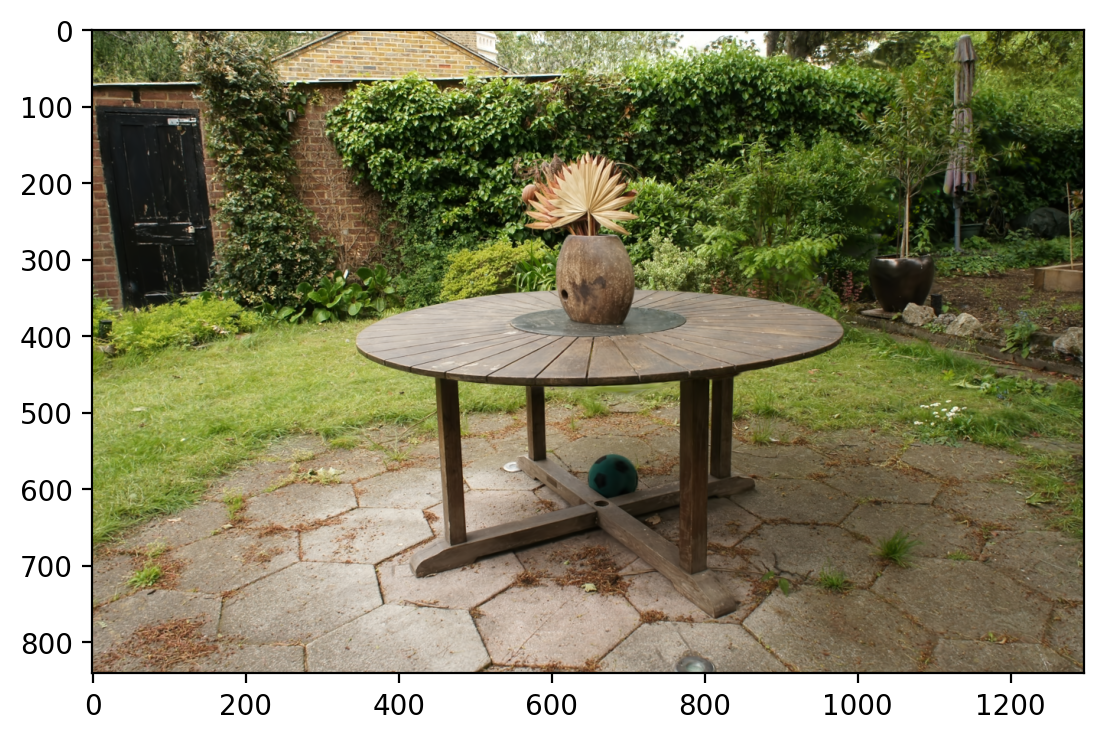

In [19]:
# For each instance to be rendered, produce adequate [ tile | depth ] key 
# and corresponding dublicated Gaussian indices to be sorted
rgb, alpha = rasterize_gaussians(
    xys=useful["points_xy_image"],
    depths=useful["depths"],
    radii=useful["radii"],
    conics=useful["conics"],
    num_tiles_hit=useful["tiles_touched"],
    colors=colors_precomp,
    opacity=model.get_opacity[selector_for_original_model],
    img_height=int(camera.height.cpu()),
    img_width=int(camera.width.cpu()),
    block_width=BLOCK_X,
    background=torch.tensor([0., 0., 0.], dtype=torch.float, device=means_in_camera_space.device),
    return_alpha=True,
)
plt.imshow(rgb.cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


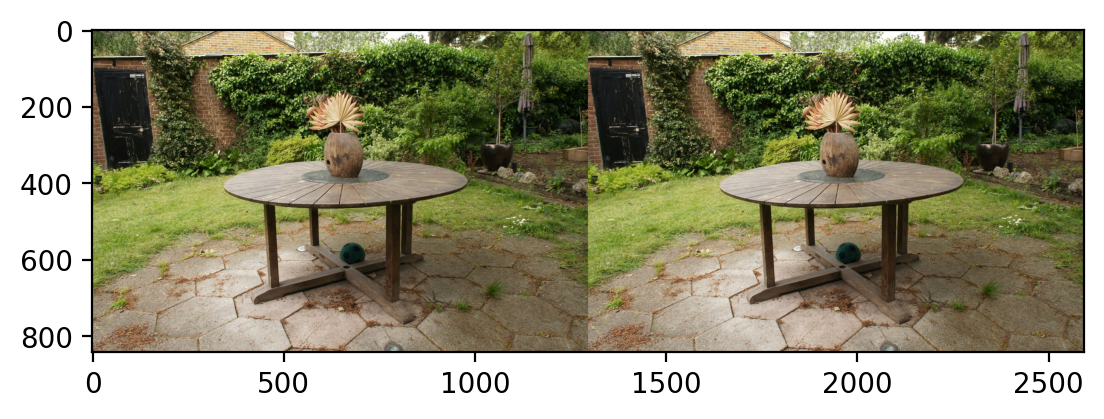

In [20]:
plt.imshow(torch.concat([rgb, results["render"].permute(1, 2, 0)], dim=1).cpu().numpy())
plt.show()

In [21]:
from torchmetrics import PeakSignalNoiseRatio
psnr = PeakSignalNoiseRatio().to(rgb.device)
psnr(rgb, results["render"].permute(1, 2, 0))

/home/zhensheng/miniconda3/envs/gaussian-splatting-pl/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(


tensor(27.3036, device='cuda:0')